In [1]:
%pip install -q "monai-weekly[tqdm,nibabel,gdown,ignite]"
# install the latest weekly preview version of MONAI

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\b_pau\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import warnings
warnings.filterwarnings("ignore") # remove some sciokit-image warnings

import monai
monai.config.print_config()

MONAI version: 0.9.dev2149
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1ad68787c35e259cb7704b56d679659104d2494c

Optional dependencies:
Pytorch Ignite version: 0.4.6
Nibabel version: 3.2.1
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.5.0a20210310
gdown version: 4.2.0
TorchVision version: 0.9.0
tqdm version: 4.50.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.7.2
pandas version: 1.1.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Initial tests


Dictionary transforms are nothing other than the wrappers of the array versions. Compared with their array-based counterparts, it's easier to apply the same type of operations or states to multiple data inputs.

The following section reads a pair of image and segmentation mask, note that the keys need to be specified, so that the transforms know which items in the dictonary should be processed. 

In [4]:
from monai.transforms import LoadImageD

dict_loader = LoadImageD(keys=("image","label"))
data_dict= dict_loader({"image":"Task05_Prostate/imagesTr/prostate_02.nii.gz",
                       "label":"Task05_Prostate/labelsTr/prostate_02.nii.gz"})
print(f"image shape:{data_dict['image'].shape}, \nlabel shape: {data_dict['label'].shape}")


image shape:(320, 320, 24, 2), 
label shape: (320, 320, 24)


C:\Users\b_pau\anaconda3\lib\site-packages\monai\data\utils.py:536: UserWarning: Modifying image pixdim from [0.625 0.625 3.6   1.   ] to [  0.625        0.625        3.5999999  160.84918933]
  warnings.warn(f"Modifying image pixdim from {pixdim} to {norm}")


In [40]:
transform=AsDiscrete(argmax=True,to_onehot=2, threshold_values=0.6)
a= np.array([[[0.0, 1.0]], [[2.0, 3.0]]])

print(a.shape)
b=transform(a)
print(b.shape)


(2, 1, 2)
(2, 1, 2)


In [41]:
from monai.transforms import LoadImageD, AsDiscrete

dict_loader = LoadImageD(keys=("image","label")) #xform
data_dict= dict_loader({"image":"pix2pixHD/datasets/brats2021/train_A/BraTS2021_00000_50.png",
                       "label":"pix2pixHD/datasets/brats2021/train_B/BraTS2021_00000_90.png"}) # return as dict inside dataset
print(f"image shape:{data_dict['image'].shape}, \nlabel shape: {data_dict['label'].shape}")

discreter=AsDiscrete(to_onehot=3,threshold_values=[10,100,200])

type(data_dict["label"][:,:,0])

label=discreter(data_dict["label"][np.newaxis,:,:,0])
# print("label shape",label.shape)

print(np.unique(data_dict["label"][:,:,0]))

image shape:(480, 480, 4), 
label shape: (480, 480, 4)


RuntimeError: index 170 is out of bounds for dimension 0 with size 3

The purpose of the dictionary loader above is to take the paths provided as values to prespecified keys. Then when the keys are called return the actual files specified by the filepaths which were stored as values.

In [25]:
import os
for a,b,c in os.walk("./"):
    print (a,"a \n",b,"b\n", c)
    nextline= input("next ?(y or n)")
    if nextline=="y":
        continue
    else:
        break
# a = root dir, where are we starting the "walk"
# b = what folders do we have in dir a
# c = what files do we have in root dir

./ a 
 ['.ipynb_checkpoints', 'dataset_exported_png', 'github', 'pix2pixHD', 'RSNA_ASNR_MICCAI_BraTS2021_TrainingData', 'RSNA_ASNR_MICCAI_BraTS2021_ValidationData', 'Task05_Prostate'] b
 ['MONAI intro.ipynb', 'PSO on MLP MNIST.ipynb', 'raw_mask.py', 'RSNA_ASNR_MICCAI_BraTS2021_ValidationData.zip', 'Task05_Prostate.tar']
next ?(y or n)n


In [27]:
os.listdir("./")[0]

'.ipynb_checkpoints'

## Dataset and loader

In [2]:
import os
# from torch.utils.data import Dataset
from monai.data import Dataset
from torchvision.io import read_image

class BratsDataset(Dataset):
    def __init__(self,image_dir,mask_dir,transform=None):
        self.image_dir=image_dir
        self.mask_dir=mask_dir
        self.transform=transform
        
    def __len__(self):
#         return len(os.listdir(self.mask_dir))
        return 100
    
    def __getitem__(self,idx):
        image_path=os.path.join(self.image_dir,os.listdir(self.image_dir)[idx])
        image=read_image(image_path)
        mask_path=os.path.join(self.mask_dir, os.listdir(self.mask_dir)[idx])
        mask=read_image(mask_path)

            
        item_dict={"image":image,"mask":mask}
        
        if self.transform:
            item_dict={"image":image_path,"mask":mask_path}
            item_dict=self.transform(item_dict)
            
        
        return item_dict
        
dataset=BratsDataset("./pix2pixHD/datasets/brats2021/train_A"  ,"./pix2pixHD/datasets/brats2021/train_B" )     

In [ ]:
# TO binarize mask
class ThresholdTransform(object):
  def __init__(self, thr_255):
    self.thr = thr_255 / 255.  # input threshold for [0..255] gray level, convert to [0..1]

  def __call__(self, x):
    return (x > self.thr).to(x.dtype)  # do not change the data type

In [3]:
import numpy as np
from monai.transforms import \
    LoadImageD, EnsureChannelFirstD, AddChannelD, ScaleIntensityD, ToTensorD, Compose, \
    AsDiscreteD, SpacingD, OrientationD, ResizeD, RandAffineD
from monai.data import DataLoader
KEYS=("image","mask")

xform=Compose([
    LoadImageD(KEYS)
    ,EnsureChannelFirstD("image")
    ,EnsureChannelFirstD("mask")
#     ,AddChannelD("mask")
    ,ToTensorD(KEYS)
])

#dataset=DecathlonDataset(root_dir="./", task="Task05_Prostate",section="training", transform=xform, download=True)
train_dataset=BratsDataset("./pix2pixHD/datasets/brats2021/train_A"  ,"./pix2pixHD/datasets/brats2021/train_B",transform=xform )
val_dataset=BratsDataset("./pix2pixHD/datasets/brats2021/test_As","./pix2pixHD/datasets/brats2021/test_B",transform=xform)
train_loader=DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=1, shuffle=True)


In [14]:
len(os.listdir("./pix2pixHD/datasets/brats2021/test_B"))
# dir(DecathlonDataset)

1530

In [15]:
item_dict={"image":"pix2pixHD/datasets/brats2021/train_A/BraTS2021_00000_50.png",
                       "mask":"pix2pixHD/datasets/brats2021/train_B/BraTS2021_00000_50.png"}
image=xform(item_dict)#
type(image)


dict

In [16]:
# DecathlonDataset.__dict__

torch.Size([1, 4, 480, 480]) ['pix2pixHD\\datasets\\brats2021\\test_As\\BraTS2021_01646_121.png']
torch.Size([1, 4, 480, 480]) None


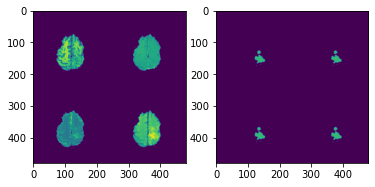

In [17]:
import matplotlib.pyplot as plt
import numpy as np

data_dit=next(iter(val_loader))
print(data_dit["image"].shape,print(data_dit["mask"].shape, data_dit["image_meta_dict"]["filename_or_obj"]))

plt.subplots(1,2)
plt.subplot(1,2,1);plt.imshow(data_dit["image"][0,2,:,:])
plt.subplot(1,2,2);plt.imshow(data_dit["mask"][0,1,:,:])

In [18]:
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss
import torch

device=torch.device(("cuda:0"))
net=UNet(dimensions=2, in_channels=1, out_channels=1, channels=(16,32,64,128,256),strides=(2,2,2,2),num_res_units=2
        ,norm=Norm.BATCH).to(device)
loss_function=DiceLoss(to_onehot_y=True, softmax=True)
opt=torch.optim.Adam(net.parameters(),1e-2)

In [30]:
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image
from monai.data import decollate_batch, list_data_collate
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.transforms import EnsureType, Activations, AsDiscrete

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)]) # learn this after model run

val_interval=2 # This is used as epoch counter to run validation later
best_metric=-1 # This is initialised such that tbe best mnetric is saved for iteration later
best_metric_epoch=-1 # same as best metric but for epoch
epoch_loss_values=list() # To store loss values
metric_values=list() # to store metric values later
writer=SummaryWriter()
for epoch in range(10): # run for the number of epochs you want to run
    print("-"*10)
    print(f"epoch{epoch+1}/{10}")
    net.train()
    epoch_loss= 0 # to store loss presumably
    step = 0 # to maintain counter for total number of batches
    for batch_data in train_loader:  # cycle through the dataset one batch at a time
        step+=1 # add 1 for each batch
        inputs,labels= torch.mean(batch_data["image"],1,True).to(device),torch.mean(batch_data["mask"],1,True).to(device)
        #since data incorrectly saved with 4 channels take mean along the channel axis
        opt.zero_grad()
        outputs=net(inputs) # forward pass of the model to give you output of the final conv block
        loss=loss_function(outputs,labels) # compare output and GT to calculate loss
        loss.backward # Back propagate calculated loss using chain rule
        opt.step() # Step each weight based on its specific contribution to the loss
        epoch_loss += loss.item() # cumulative sum of losses through the epoch
        epoch_len = len(train_dataset) // train_loader.batch_size # how many batches in a epoch
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}") # print which batch out of total batches
        writer.add_scalar("train_loss",loss.item(),epoch_len * epoch + step)
    epoch_loss /= step # average loss at each batch in a given epoch
    epoch_loss_values.append(epoch_loss) # adding to the loss list for plotting later
    print(f"epoch {epoch+1} average loss: {epoch_loss: .4f}")
    
    if (epoch+1)% val_interval ==0: # ie run only at every x eppochs where x=val_interval
        net.eval()
        with torch.no_grad():
            val_images=None # initialising so you don't get an error? Can i remove this
            val_labels= None
            val_outputs= None
            for val_data in val_loader:
                val_images, val_labels= torch.mean(val_data["image"],1, True).to(device), torch.mean(val_data["mask"],1,True)
                roi_size=(96,96) # load images in patches using ROI. Interesting how this is only called at eval
                sw_batch_size =4 # sliding window batch size
                val_outputs = sliding_window_inference(val_images,roi_size,sw_batch_size, net) # Learn later
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)] # learn after first successful run
                
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
            
            #aggregate the final mean dice result
            metric= dice_metric.aggregate().item()
            #reset the status for next validation round
            dice_metric.reset()
            
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(net.state_dict(), "best_metric_model_segmentation2d_dict.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)
            # plot the last model output as GIF image in TensorBoard with the corresponding image and label
            plot_2d_or_3d_image(val_images, epoch + 1, writer, index=0, tag="image")
            plot_2d_or_3d_image(val_labels, epoch + 1, writer, index=0, tag="label")
            plot_2d_or_3d_image(val_outputs, epoch + 1, writer, index=0, tag="output")

    print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")
    writer.close()    
    

----------
epoch1/10
1/100, train_loss: 1.1758
2/100, train_loss: 1.1774
3/100, train_loss: 1.1910
4/100, train_loss: 1.1492
5/100, train_loss: 1.1815
6/100, train_loss: 1.1677
7/100, train_loss: 1.1713
8/100, train_loss: 1.1461
9/100, train_loss: 1.1723
10/100, train_loss: 1.2071
11/100, train_loss: 1.1474
12/100, train_loss: 1.1861
13/100, train_loss: 1.1743
14/100, train_loss: 1.1517
15/100, train_loss: 1.1809
16/100, train_loss: 1.1534
17/100, train_loss: 1.2004
18/100, train_loss: 1.1636
19/100, train_loss: 1.1692
20/100, train_loss: 1.1363
21/100, train_loss: 1.1598
22/100, train_loss: 1.1365
23/100, train_loss: 1.1742
24/100, train_loss: 1.1737
25/100, train_loss: 1.1406
26/100, train_loss: 1.1825
27/100, train_loss: 1.1799
28/100, train_loss: 1.1566
29/100, train_loss: 1.1611
30/100, train_loss: 1.1718
31/100, train_loss: 1.1397
32/100, train_loss: 1.1765
33/100, train_loss: 1.1493
34/100, train_loss: 1.1598
35/100, train_loss: 1.2070
36/100, train_loss: 1.1520
37/100, train_lo

ValueError: y should be a binarized tensor.

In [ ]:
from monai.metric import DiceMetric


In [ ]:
from torch.autograd import Variable

for epoch in range(10):
    losses,generated=
    

## Ignite

In [31]:
import ignite
print(ignite.__version__)

0.4.6


In [34]:

from monai.engines import SupervisedTrainer
from monai.inferers import SlidingWindowInferer
from monai.handlers import StatsHandler, MeanDice, from_engine
from monai.transforms import AsDiscreteD

import sys
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

trainer = SupervisedTrainer(
    device=device,
    max_epochs=2,
    train_data_loader=data_loader,
    network=net,
    optimizer=opt,
    loss_function=loss,
#     inferer=SlidingWindowInferer((32, 32), sw_batch_size=1),
    postprocessing=AsDiscreteD(keys=["pred", "label"], argmax=(True, False), to_onehot=True, n_classes=3),
    key_train_metric={"train_meandice": MeanDice(output_transform=from_engine(["pred", "label"]))},
    train_handlers=StatsHandler(tag_name="train_loss", output_transform=from_engine(["loss"], first=True)),
)
trainer.run()

INFO:ignite.engine.engine.SupervisedTrainer:Engine run resuming from iteration 0, epoch 0 until 2 epochs
ERROR:ignite.engine.engine.SupervisedTrainer:Current run is terminating due to exception: 'NoneType' object has no attribute 'ndim'
ERROR:ignite.engine.engine.SupervisedTrainer:Exception: 'NoneType' object has no attribute 'ndim'
Traceback (most recent call last):
  File "C:\Users\b_pau\anaconda3\lib\site-packages\ignite\engine\engine.py", line 834, in _run_once_on_dataset
    self.state.output = self._process_function(self, self.state.batch)
  File "C:\Users\b_pau\anaconda3\lib\site-packages\monai\engines\trainer.py", line 206, in _iteration
    _compute_pred_loss()
  File "C:\Users\b_pau\anaconda3\lib\site-packages\monai\engines\trainer.py", line 188, in _compute_pred_loss
    engine.state.output[Keys.LOSS] = self.loss_function(engine.state.output[Keys.PRED], targets).mean()
  File "C:\Users\b_pau\anaconda3\lib\site-packages\torch\nn\modules\module.py", line 889, in _call_impl
   

AttributeError: 'NoneType' object has no attribute 'ndim'

In [36]:
3%5

3

# RANDOM TIPS


In [28]:
from pathlib import Path
a=Path("am")
b="rt"
c=a/b
print(c)

am\rt
